<a href="https://colab.research.google.com/github/SajjadRahati1/Index/blob/main/EuroPricePrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip install keras
!pip install pandas
!pip install numpy

In [2]:
!pip install sklearn

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [50]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# فرض کنید data_frame یک DataFrame Pandas با دو ستون (Date و Price) باشد
file = '/content/sample_data/dataEuroPrice.csv'
data_frame = pd.read_csv(file)
data_frame['Date'] = pd.to_datetime(data_frame['Date'])
data_frame = data_frame.sort_values(by='Date')
data_frame = data_frame.set_index('Date')
# print(data_frame)

# تقسیم داده‌ها به داده‌های آموزش و آزمون
# train_data = data_frame.iloc[:2000, :]
# test_data = data_frame.iloc[2000:, :]
train_data = data_frame.iloc[:-30, :]
test_data = data_frame.iloc[-30:, :]

In [51]:

# نرمال‌سازی داده‌ها
scaler = MinMaxScaler(feature_range=(0, 1))
train_data_scaled = scaler.fit_transform(train_data[['Final']])
test_data_scaled = scaler.transform(test_data[['Final']])



In [52]:

# ساخت داده‌های ورودی و خروجی برای شبکه
def create_dataset(data, time_step):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

time_step = 10
X_train, y_train = create_dataset(train_data_scaled, time_step)
X_test, y_test = create_dataset(test_data_scaled, time_step)


In [53]:

# تغییر شکل داده‌های ورودی برای استفاده در LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)


In [54]:
from keras.models import Sequential
from keras.layers import LSTM, Dense



# ساخت معماری شبکه عصبی
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=1))

In [55]:

# کompای کردن مدل
model.compile(optimizer='adam', loss='mean_squared_error')

# آموزش مدل
model.fit(X_train, y_train, epochs=100, batch_size=32)

# ارزیابی مدل
loss = model.evaluate(X_test, y_test)
print('Test Loss:', loss)

Epoch 1/100
105/105 [==============================] - 7s 12ms/step - loss: 0.0083
Epoch 2/100
105/105 [==============================] - 1s 13ms/step - loss: 1.7089e-04
Epoch 3/100
105/105 [==============================] - 2s 18ms/step - loss: 1.6904e-04
Epoch 4/100
105/105 [==============================] - 1s 13ms/step - loss: 1.7881e-04
Epoch 5/100
105/105 [==============================] - 1s 13ms/step - loss: 1.6959e-04
Epoch 6/100
105/105 [==============================] - 2s 16ms/step - loss: 1.8478e-04
Epoch 7/100
105/105 [==============================] - 2s 19ms/step - loss: 1.8919e-04
Epoch 8/100
105/105 [==============================] - 1s 13ms/step - loss: 1.7157e-04
Epoch 9/100
105/105 [==============================] - 1s 13ms/step - loss: 1.6380e-04
Epoch 10/100
105/105 [==============================] - 1s 12ms/step - loss: 2.5519e-04
Epoch 11/100
105/105 [==============================] - 1s 13ms/step - loss: 2.2299e-04
Epoch 12/100
105/105 [=======================

In [56]:

# پیش‌بینی قیمت‌های یورو برای داده‌های آزمون
predictionsBeforeInverse = model.predict(X_test)
predictions = scaler.inverse_transform(predictionsBeforeInverse)


1/1 [==============================] - 1s 1s/step


In [57]:

# پیش‌بینی قیمت‌های آینده
last_data = train_data_scaled[-time_step:].reshape(1, -1)
future_predictions = []

for i in range(30):
    prediction = model.predict(last_data.reshape(1, time_step, 1))[0, 0]
    future_predictions.append(prediction)
    last_data = np.append(last_data[:, 1:], [[prediction]], axis=1)


1/1 [==============================] - 0s 24ms/step


In [58]:
data_frame.index.max()

Timestamp('2024-03-18 00:00:00')

In [60]:
from datetime import datetime, timedelta
# بازگشت به مقیاس اصلی
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# تولید تاریخ‌های آینده
last_date = data_frame.index.max()
future_dates = [(last_date + timedelta(days=i)).strftime('%Y/%m/%d') for i in range(1, 31)]

# نمایش پیش‌بینی‌ها
future_predictions_df = pd.DataFrame({'Date': future_dates, 'Predicted_Price': future_predictions.flatten()})
# تغییر فرمت اعداد به صورت عدد اعشاری
future_predictions_df['Predicted_Price'] = future_predictions_df['Predicted_Price'].apply(lambda x: '{:.2f}'.format(x))

print(future_predictions_df)
future_predictions_df.to_csv('/content/sample_data/futurePredictions.csv', index=False)


          Date  Predicted_Price
0   2024/03/19  371303219200.00
1   2024/03/20  381704994816.00
2   2024/03/21  391017431040.00
3   2024/03/22  399717466112.00
4   2024/03/23  407827316736.00
5   2024/03/24  415403835392.00
6   2024/03/25  422568361984.00
7   2024/03/26  429357203456.00
8   2024/03/27  435928596480.00
9   2024/03/28  442401161216.00
10  2024/03/29  448799473664.00
11  2024/03/30  455079264256.00
12  2024/03/31  461195575296.00
13  2024/04/01  467119800320.00
14  2024/04/02  472833687552.00
15  2024/04/03  478327046144.00
16  2024/04/04  483595124736.00
17  2024/04/05  488637890560.00
18  2024/04/06  493457178624.00
19  2024/04/07  498056429568.00
20  2024/04/08  502438789120.00
21  2024/04/09  506607599616.00
22  2024/04/10  510566531072.00
23  2024/04/11  514319810560.00
24  2024/04/12  517872353280.00
25  2024/04/13  521229860864.00
26  2024/04/14  524398460928.00
27  2024/04/15  527384870912.00
28  2024/04/16  530196201472.00
29  2024/04/17  532839694336.00


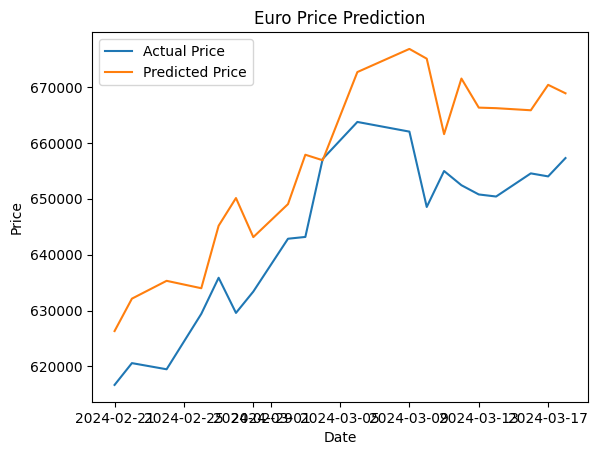

In [62]:
import matplotlib.pyplot as plt

# نمایش قیمت‌های پیش‌بینی شده
plt.plot(test_data[['Final']].index[time_step:], test_data[['Final']].values[time_step:], label='Actual Price')
plt.plot(test_data[['Final']].index[time_step:], predictions, label='Predicted Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Euro Price Prediction')
plt.legend()
plt.show()